In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sst

import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

### Replicate

In [2]:
X = 50  
sigma = 0.2  
r = 0.05  
time_to_maturity_weeks = 20 
shares_per_call = 100_000  


# 주어진 주가
stock_prices = [49, 48.125, 47.375, 50.25, 51.75, 53.125, 53, 51.875, 51.375, 53, 49.875, 
                48.5, 49.875, 50.375, 52.125, 51.875, 52.875, 54.875, 54.625, 55.875, 57.25]

weeks = list(range(len(stock_prices)))
deltas = []
shares_purchased = []
cost_of_shares_purchased = []
cumulative_costs = []
interest_costs = []

cumulative_cost = 0

# Delta 및 비용 계산
for i, S in enumerate(stock_prices):
    # 남은 기간 계산 (annualize)
    time_remaining = (time_to_maturity_weeks - weeks[i]) / 52

    # Black-Scholes d1 계산
    d1 = (np.log(S / X) + (r + sigma ** 2 / 2) * time_remaining) / (sigma * np.sqrt(time_remaining))

    # Delta 계산
    delta = sst.norm.cdf(d1) 
    delta = round(delta, 3)  
    deltas.append(delta)

    # Shares Purchased 계산
    if i == 0:
        shares_purchased.append(delta * shares_per_call)
    else:
        shares_purchased.append((round(delta, 3) - round(deltas[i - 1], 3)) * shares_per_call)

    # Cost of Shares Purchased 계산
    cost = shares_purchased[i] * S / 1_000  # 천 달러 단위
    cost_of_shares_purchased.append(cost)

    # Cumulative Cost 및 Interest Cost 계산
    if i == 0:
        # 첫 번째 주
        cumulative_cost = cost
        cumulative_costs.append(cumulative_cost)
        interest = cumulative_cost * (r / 52)
        interest_costs.append(interest)
    else:
        # 나머지 주
        cumulative_cost = cumulative_cost + cost + interest
        cumulative_costs.append(cumulative_cost)
        interest = cumulative_cost * (r / 52)
        interest_costs.append(interest)

data = {
    "Week": weeks,
    "Stock Price": stock_prices,
    "Delta": deltas,
    "Shares Purchased": shares_purchased,
    "Cost of Shares Purchased (Thousands of Dollars)": cost_of_shares_purchased,
    "Cumulative Cost (Incl. Interest, in Thousands of Dollars)": cumulative_costs,
    "Interest Cost (Thousands of Dollars)": interest_costs,
}

df = pd.DataFrame(data)

df.round(1)

,Week,Stock Price,Delta,Shares Purchased,Cost of Shares Purchased (Thousands of Dollars),"Cumulative Cost (Incl. Interest, in Thousands of Dollars)",Interest Cost (Thousands of Dollars)
0,0,49.0,0.5,52200.0,2557.8,2557.8,2.5
1,1,48.1,0.5,-6400.0,-308.0,2252.3,2.2
2,2,47.4,0.4,-5800.0,-274.8,1979.7,1.9
3,3,50.2,0.6,19600.0,984.9,2966.5,2.9
4,4,51.8,0.7,9700.0,502.0,3471.3,3.3
5,5,53.1,0.8,8100.0,430.3,3904.9,3.8
6,6,53.0,0.8,-300.0,-15.9,3892.8,3.7
7,7,51.9,0.7,-6500.0,-337.2,3559.3,3.4
8,8,51.4,0.7,-3200.0,-164.4,3398.4,3.3
9,9,53.0,0.8,11300.0,598.9,4000.5,3.8


### n=1 path 생성

In [3]:
# Delta 계산 함수
def delta(S, X, r, q, t, sigma, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return sst.norm.cdf(d1) if flag.lower() == 'call' else sst.norm.cdf(d1) - 1

# GBM 기반 주가 경로 생성
def simulate_stock_paths(S, mu, q, sigma, t, nsim, interval):
    dt = interval / 52  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps
    z = np.random.randn(nsim, m - 1)
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로
    return stock_paths
# Delta 헷징 비용 및 결과 계산
def calculate_hedging_cost(stock_paths, X, r, sigma, t, flag, shares_per_call, dt):
    nsim, m = stock_paths.shape
    deltas = np.zeros(m)
    shares_purchased = np.zeros(m)
    cost_of_shares_purchased = np.zeros(m)
    cumulative_costs = np.zeros(m)
    interest_costs = np.zeros(m)
    stock_prices = stock_paths[0]  # 첫 번째 경로를 선택

    for i in range(m):
        tau = max(1e-10, t - i * dt)  # 음수 방지
        deltas[i] = round(delta(stock_prices[i], X, r, 0, tau, sigma, flag), 3)

        if i == 0:
            shares_purchased[i] = deltas[i] * shares_per_call
            cost_of_shares_purchased[i] = shares_purchased[i] * stock_prices[i] / 1000
            cumulative_costs[i] = cost_of_shares_purchased[i]
        else:
            shares_purchased[i] = (deltas[i] - deltas[i - 1]) * shares_per_call
            cost_of_shares_purchased[i] = shares_purchased[i] * stock_prices[i] / 1000
            interest = cumulative_costs[i - 1] * (r * dt)  # Interest Cost
            interest_costs[i] = interest
            cumulative_costs[i] = cumulative_costs[i - 1] + cost + interest

    # 마지막 누적 비용과 조건에 따라 헷징 비용 계산
    final_cost = cumulative_costs[-1]
    hedge_cost = final_cost - 5000 if stock_prices[-1] >= X else final_cost
    return stock_prices, deltas, shares_purchased, cost_of_shares_purchased, cumulative_costs, interest_costs, hedge_cost

# 결과 테이블 생성
def delta_hedging_simulation(S, X, mu, r, sigma, t, nsim, interval, shares_per_call, flag):
    dt = interval / 52
    stock_paths = simulate_stock_paths(S, mu, 0, sigma, t, nsim, interval)
    stock_prices, deltas, shares_purchased, cost_of_shares_purchased, cumulative_costs, interest_costs, hedge_cost = calculate_hedging_cost(
        stock_paths, X, r, sigma, t, flag, shares_per_call, dt
    )

    data = {
        "Week": list(range(len(stock_prices))),
        "Stock Price": stock_prices.round(2),
        "Delta": deltas.round(3),
        "Shares Purchased": shares_purchased.round(),
        "Cost of Shares Purchased (Thousands of Dollars)": cost_of_shares_purchased.round(2),
        "Cumulative Cost (Incl. Interest, in Thousands of Dollars)": cumulative_costs.round(2),
        "Interest Cost (Thousands of Dollars)": interest_costs.round(1),
    }

    df = pd.DataFrame(data)
    return hedge_cost, df
# 입력 값
S, X, mu, r, sigma = 49, 50, 0.13, 0.05, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 1
interval = 1  # Rebalancing interval in weeks
shares_per_call = 100_000
flag = 'call'

# 실행
hedge_cost, df = delta_hedging_simulation(S, X, mu, r, sigma, t, nsim, interval, shares_per_call, flag)
print("Hedge Cost: $", 1000*hedge_cost)
df

Hedge Cost: $ -2392559.617940784


,Week,Stock Price,Delta,Shares Purchased,Cost of Shares Purchased (Thousands of Dollars),"Cumulative Cost (Incl. Interest, in Thousands of Dollars)",Interest Cost (Thousands of Dollars)
0,0,49.00,0.522,52200.0,2557.80,2557.80,0.0
1,1,49.49,0.551,2900.0,143.53,2560.26,2.5
2,2,50.29,0.600,4900.0,246.40,2562.72,2.5
3,3,49.58,0.550,-5000.0,-247.88,2565.19,2.5
4,4,49.64,0.551,100.0,4.96,2567.65,2.5
5,5,50.03,0.577,2600.0,130.07,2570.12,2.5
6,6,49.95,0.569,-800.0,-39.96,2572.59,2.5
7,7,48.41,0.441,-12800.0,-619.60,2575.07,2.5
8,8,49.89,0.557,11600.0,578.67,2577.54,2.5
9,9,50.63,0.617,6000.0,303.80,2580.02,2.5


### n=1 path (승한)

In [4]:
import numpy as np
import pandas as pd

# Parameters
S0 = 49  # Initial stock price
X = 50  # Strike price
r = 0.05  # Annual risk-free rate
sigma = 0.2  # Volatility

q = 0  # Dividend yield
steps = 20  # Number of steps (weeks)
T = steps/ 52  # Time to maturity in years (20 weeks)
N = 100_000  # Number of stocks

# Black-Scholes delta calculation
def calculate_delta(S, X, T, r, sigma):
    from scipy.stats import norm
    d1 = (np.log(S / X) + (r -q+ 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def tables(S0,X,r,sigma,steps,N):
    T = steps/ 52
# Initialize variables
    weeks = list(range(steps + 1))
    stock_prices = [S0]
    deltas = []
    shares_purchased = []
    cost_of_shares = []
    cumulative_cost = []
    interest_cost = []


    # Simulate stock price changes and calculate delta
    #np.random.seed(42)  # For reproducibility
    for i in range(steps + 1):
        T_remaining = T - (i / 52)
        S = stock_prices[-1]
      
        # Calculate delta
        delta = calculate_delta(S, X, T_remaining, r, sigma)
        deltas.append(delta)

        # Simulate stock price for the next week
        if i < steps:
            S_new = S * np.exp((r - q+0.5 * sigma**2) * (1 / 52) + sigma * np.sqrt(1 / 52) * np.random.normal())
            stock_prices.append(S_new)

        # Calculate shares to purchase/sell
        if i == 0:
            shares_to_buy = delta * N
        else:
            shares_to_buy = (delta - deltas[i - 1]) * N

        shares_purchased.append(shares_to_buy)

        # Calculate cost of shares purchased (in thousands)
        cost = shares_to_buy * S / 1000
        cost_of_shares.append(cost)

        # Calculate cumulative cost (including interest)
        if i == 0:
            cumulative_cost.append(cost)
        else:
            cumulative_cost.append(cumulative_cost[-1] + cost + interest_cost[-1])

        # Calculate interest cost
        interest = cumulative_cost[-1] * (r / 52)
        interest_cost.append(interest)
    final_cost = cumulative_cost[-1]
    hedge_cost = final_cost - 5000 if stock_prices[-1] >= X else final_cost

    stock_prices = np.array(stock_prices)
    deltas = np.array(deltas)
    shares_purchased = np.array(shares_purchased)
    cost_of_shares = np.array(cost_of_shares)
    cumulative_cost = np.array(cumulative_cost)
    interest_cost = np.array(interest_cost)
    
    # Create a DataFrame for the results
    results = pd.DataFrame({
        'Week': weeks,
        'Stock Price': stock_prices.round(2),
        'Delta': deltas.round(3),
        'Shares Purchased': shares_purchased.round(),
        'Cost of Shares (Thousands)': cost_of_shares.round(2),
        'Cumulative Cost (Thousands)': cumulative_cost.round(2),
        'Interest Cost (Thousands)': interest_cost.round(1)
    })
    return results, hedge_cost

# Display the DataFrame
results, hedge_cost=tables(S0,X,r,sigma,steps,N)
print("Hedge Cost: $", 1000*round(hedge_cost,3))
results
# Print total hedge cost


Hedge Cost: $ 238148.0


,Week,Stock Price,Delta,Shares Purchased,Cost of Shares (Thousands),Cumulative Cost (Thousands),Interest Cost (Thousands)
0,0,49.00,0.522,52160.0,2555.86,2555.86,2.5
1,1,50.45,0.613,9102.0,459.20,3017.52,2.9
2,2,51.52,0.677,6476.0,333.65,3354.07,3.2
3,3,51.00,0.646,-3182.0,-162.27,3195.02,3.1
4,4,49.78,0.561,-8428.0,-419.55,2778.54,2.7
5,5,48.97,0.497,-6382.0,-312.51,2468.70,2.4
6,6,47.67,0.390,-10703.0,-510.21,1960.87,1.9
7,7,46.69,0.305,-8519.0,-397.78,1564.98,1.5
8,8,47.82,0.384,7869.0,376.33,1942.82,1.9
9,9,47.21,0.322,-6226.0,-293.96,1650.73,1.6


### path n개

In [5]:
#BSM 옵션 이론가 계산
def bsprice(s, k, r, q, t, sigma, flag):
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    callOrPut = 1 if flag.lower()=='call' else -1
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price = callOrPut*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    return price

In [6]:
# Delta 계산 함수
def delta(S, X, r, q, t, sigma, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return sst.norm.cdf(d1) if flag.lower() == 'call' else sst.norm.cdf(d1) - 1

### Delta와 Share purchased를 Rounding 안하고 헷지비용 계산

In [7]:
# 주가 경로 생성 및 헤지 비용 계산
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 52  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # Hedging 비용 계산
    deltas = np.zeros((nsim, m))
    shares_purchased = np.zeros_like(deltas)
    transaction_costs = np.zeros_like(stock_paths)
    cumulative_costs = np.zeros_like(stock_paths)
    interest_costs = np.zeros_like(stock_paths)

    for i in range(m):
        # 남은 시간 계산 (tau)
        tau = max(1e-10/52, t - i * dt)  # 음수 방지

        # Delta 계산
        deltas[:, i] = delta(stock_paths[:, i], X, r, q, tau, sigma, flag)

        # Shares Purchased 계산
        if i == 0:
            shares_purchased[:, i] = deltas[:, i] * shares_per_call
        else:
            shares_purchased[:, i] = (deltas[:, i] - deltas[:, i - 1]) * shares_per_call
        shares_purchased=shares_purchased.round()  #정수만 purchase

        # Cost of share purchased
        cost = shares_purchased[:, i] * stock_paths[:, i]  # 현재 주가 * 매수/매도 주식 수

        # Cumulative Cost & Interest Cost
        if i == 0:
            cumulative_costs[:, i] = cost  
        else:
            interest = cumulative_costs[:, i - 1] * (r * dt)  # Interest Cost
            interest_costs[:, i] = interest
            cumulative_costs[:, i] = cumulative_costs[:, i - 1] + cost + interest

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] >= X, final_cost - 5000000, final_cost)

    return hedge_cost

# 델타 헷징 시뮬레이션
def delta_hedging_simulation():
    # 옵션 가격
    theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

    # 리밸런싱 주기별 성능 측정
    results = []
    for interval in rebalancing_intervals:
        hedge_cost = simulate_and_calculate_hedging_cost(
            S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
        )
        performance_measure = round(np.std(hedge_cost - theoretical_price) / theoretical_price,3)
        mean = round(np.mean(hedge_cost),0)
        bias = round(np.abs((np.mean(hedge_cost) - theoretical_price))/theoretical_price *100,3)
        results.append([interval, performance_measure, mean, bias])

    df = pd.DataFrame(results, columns=["Rebalancing Interval (weeks)", "Performance Measure", "mean", "hedge error(%)"])
    return df
np.random.seed(123)
S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 100000
rebalancing_intervals = [5, 4, 2, 1, 0.5, 0.25] 
shares_per_call = 100_000
flag = 'call'

df = delta_hedging_simulation() 
df


,Rebalancing Interval (weeks),Performance Measure,mean,hedge error(%)
0,5.00,0.424,246295.0,2.600
1,4.00,0.381,246311.0,2.607
2,2.00,0.274,245425.0,2.238
3,1.00,0.196,245193.0,2.141
4,0.50,0.140,245046.0,2.080
5,0.25,0.100,244787.0,1.972


### 헤지 주기에 따른 상대 P&L 히스토그램

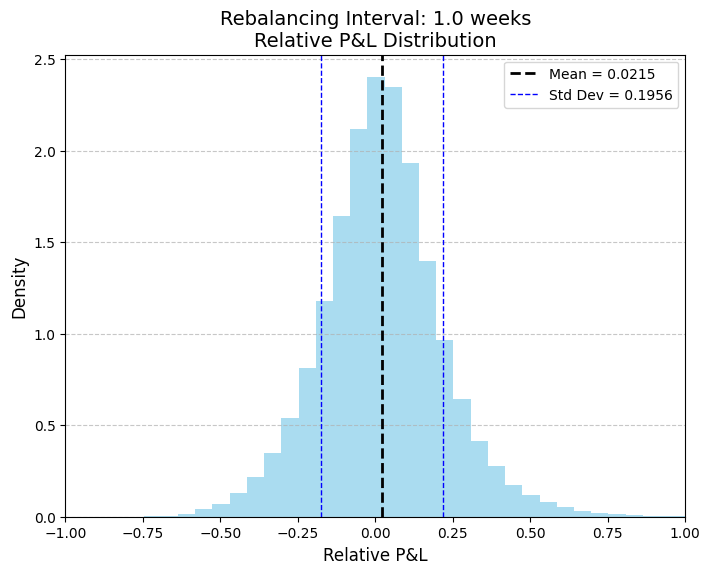

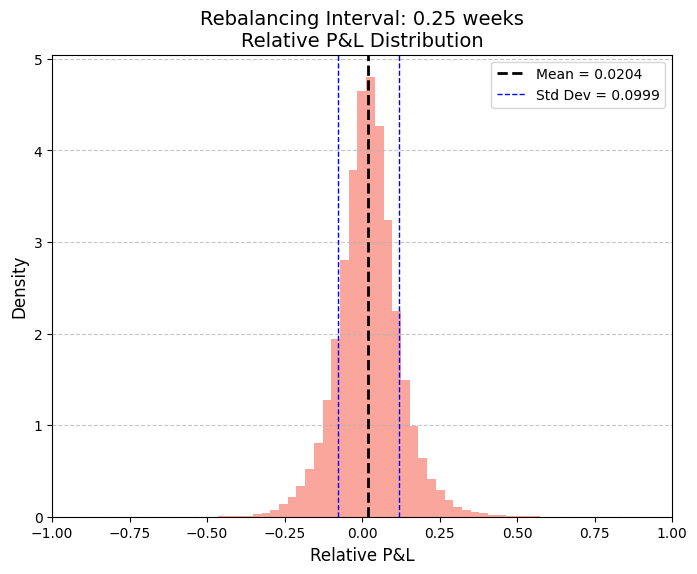

In [10]:
np.random.seed(123)
S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 100000
shares_per_call = 100_000
flag = 'call'

# Theoretical price
theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

# Rebalancing intervals
intervals_to_plot = [1.0, 0.25]
hedge_costs = {}

# Calculate hedge costs for intervals
for interval in intervals_to_plot:
    hedge_costs[interval] = simulate_and_calculate_hedging_cost(
        S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
    )

# Create histograms with colors and include mean and standard deviation annotations
for interval, costs in hedge_costs.items():
    relative_pnl = (costs - theoretical_price) / theoretical_price
    mean_pnl = np.mean(relative_pnl)
    std_pnl = np.std(relative_pnl)
    
    plt.figure(figsize=(8, 6))
    plt.hist(relative_pnl, bins=40, density=True, color='skyblue' if interval == 1.0 else 'salmon', alpha=0.7)
    plt.axvline(mean_pnl, color='black', linestyle='--', linewidth=2, label=f"Mean = {mean_pnl:.4f}")
    plt.axvline(mean_pnl - std_pnl, color='blue', linestyle='--', linewidth=1, label=f"Std Dev = {std_pnl:.4f}")
    plt.axvline(mean_pnl + std_pnl, color='blue', linestyle='--', linewidth=1)
    
    plt.title(f"Rebalancing Interval: {interval} weeks\nRelative P&L Distribution", fontsize=14)
    plt.xlabel("Relative P&L", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(-1.0, 1.0)
    plt.show()

### Delta와 Share purchased에 Rounding 포함한 헷지비용 계산

In [233]:
# 주가 경로 생성 및 헤지 비용 계산
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 52  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # Hedging 비용 계산
    deltas = np.zeros((nsim, m))
    shares_purchased = np.zeros_like(deltas)
    transaction_costs = np.zeros_like(stock_paths)
    cumulative_costs = np.zeros_like(stock_paths)
    interest_costs = np.zeros_like(stock_paths)

    for i in range(m):
        # 만기까지의 기간 (tau)
        tau = max(0, t - i * dt)  # 음수 방지

        # Rounding 적용된 Delta 계산
        deltas[:, i] = np.round(delta(stock_paths[:, i], X, r, q, tau, sigma, flag), 3)

        # Shares Purchased 계산
        if i == 0:
            shares_purchased[:, i] = deltas[:, i] * shares_per_call
        else:
            shares_purchased[:, i] = (deltas[:, i] - deltas[:, i - 1]) * shares_per_call

        # Cost of share purchased
        cost = shares_purchased[:, i] * stock_paths[:, i]  # 현재 주가와 매수/매도 주식 수

        # Cumulatice Cost & Interest Cost
        if i == 0:
            cumulative_costs[:, i] = cost  # 초기 비용
        else:
            interest = cumulative_costs[:, i - 1] * (r * dt)  # Interest Cost
            interest_costs[:, i] = interest
            cumulative_costs[:, i] = cumulative_costs[:, i - 1] + cost + interest

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - 5000000, final_cost)

    return hedge_cost

# 델타 헷징 시뮬레이션
def delta_hedging_simulation():
    # 옵션 가격
    theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

    # 리밸런싱 주기별 성능 측정
    results = []
    for interval in rebalancing_intervals:
        hedge_cost = simulate_and_calculate_hedging_cost(
            S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
        )
        performance_measure = np.std(hedge_cost) / theoretical_price 
        results.append([interval, performance_measure])

    df = pd.DataFrame(results, columns=["Rebalancing Interval (weeks)", "Performance Measure"])
    return df

S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 1000000
rebalancing_intervals = [5, 4, 2, 1, 0.5, 0.25]  # Rebalancing in weeks
shares_per_call = 100_000
flag = 'call'

df = delta_hedging_simulation() 
df

,Rebalancing Interval (weeks),Performance Measure
0,5.00,0.423692
1,4.00,0.381386
2,2.00,0.273345
3,1.00,0.196000
4,0.50,0.140268
5,0.25,0.099825


### 거래비용 포함

In [237]:
# 거래비용 10bp
# 주가 경로 생성 및 헤지 비용 계산
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 52  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # Hedging 비용 계산
    deltas = np.zeros((nsim, m))
    shares_purchased = np.zeros_like(deltas)
    transaction_costs = np.zeros_like(stock_paths)
    cumulative_costs = np.zeros_like(stock_paths)
    interest_costs = np.zeros_like(stock_paths)

    for i in range(m):
        # 남은 시간 계산 (tau)
        tau = max(0, t - i * dt)  # 음수 방지

        # Delta 계산
        deltas[:, i] = delta(stock_paths[:, i], X, r, q, tau, sigma, flag)

        # Shares Purchased 계산
        if i == 0:
            shares_purchased[:, i] = deltas[:, i] * shares_per_call
        else:
            shares_purchased[:, i] = (deltas[:, i] - deltas[:, i - 1]) * shares_per_call
        shares_purchased=shares_purchased.round()  #정수만 purchase
        
        # Transaction Cost
        cost = shares_purchased[:, i] * stock_paths[:, i]  # 주당가격 곱하기 매수/매도 주식 수
        transaction_costs[:, i] = np.abs(cost) * 0.0010  # 거래 비용 계산

        # Cumulatice Cost & Interest Cost
        if i == 0:
            cumulative_costs[:, i] = cost  # 초기 비용은 거래 비용만
        else:
            interest = cumulative_costs[:, i - 1] * (r * dt)  # Interest Cost
            interest_costs[:, i] = interest
            cumulative_costs[:, i] = cumulative_costs[:, i - 1] + cost + interest

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - 5000000, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    return stock_paths, hedge_cost, hedge_cost_with_transaction

# 델타 헷징 시뮬레이션
def delta_hedging_simulation():
    # 옵션 가격
    theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

    # 리밸런싱 주기별 성능 측정
    results = []
    for interval in rebalancing_intervals:
        stock_paths, hedge_cost, hedge_cost_with_transaction = simulate_and_calculate_hedging_cost(
            S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
        )
        performance_measure = round(np.std(hedge_cost) / theoretical_price,3) 
        performance_measure_with_transaction = round(np.std(hedge_cost_with_transaction) / theoretical_price,3)
        results.append([interval, performance_measure, performance_measure_with_transaction])

    df = pd.DataFrame(results, columns=["Rebalancing Interval (weeks)", "Performance Measure", "Performance Measure (with Transaction)"])
    return df
np.random.seed(123)
S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 1000000
rebalancing_intervals = [5, 4, 2, 1, 0.5, 0.25]  # Rebalancing in weeks
shares_per_call = 100_000
flag = 'call'

df = delta_hedging_simulation() 
df


,Rebalancing Interval (weeks),Performance Measure,Performance Measure (with Transaction)
0,5.00,0.424,0.425
1,4.00,0.381,0.382
2,2.00,0.274,0.275
3,1.00,0.196,0.198
4,0.50,0.140,0.143
5,0.25,0.100,0.104


### 거래비용 포함 MSE 계산

In [239]:
# 거래비용 10bp
# 주가 경로 생성 및 헤지 비용 계산
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 52  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # Hedging 비용 계산
    deltas = np.zeros((nsim, m))
    shares_purchased = np.zeros_like(deltas)
    transaction_costs = np.zeros_like(stock_paths)
    cumulative_costs = np.zeros_like(stock_paths)
    interest_costs = np.zeros_like(stock_paths)

    for i in range(m):
        # 남은 시간 계산 (tau)
        tau = max(0, t - i * dt)  # 음수 방지

        # Delta 계산
        deltas[:, i] = delta(stock_paths[:, i], X, r, q, tau, sigma, flag)

        # Shares Purchased 계산
        if i == 0:
            shares_purchased[:, i] = deltas[:, i] * shares_per_call
        else:
            shares_purchased[:, i] = (deltas[:, i] - deltas[:, i - 1]) * shares_per_call
        shares_purchased=shares_purchased.round()  #정수만 purchase
        
        # Transaction Cost
        cost = shares_purchased[:, i] * stock_paths[:, i]  # 주당가격 곱하기 매수/매도 주식 수
        transaction_costs[:, i] = np.abs(cost) * 0.0010  # 거래 비용 계산

        # Cumulatice Cost & Interest Cost
        if i == 0:
            cumulative_costs[:, i] = cost  # 초기 비용은 거래 비용만
        else:
            interest = cumulative_costs[:, i - 1] * (r * dt)  # Interest Cost
            interest_costs[:, i] = interest
            cumulative_costs[:, i] = cumulative_costs[:, i - 1] + cost + interest

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - 5000000, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    return hedge_cost, hedge_cost_with_transaction

# 델타 헷징 시뮬레이션
def delta_hedging_simulation():
    # 옵션 가격
    theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

    # 리밸런싱 주기별 성능 측정
    results = []
    for interval in rebalancing_intervals:
        hedge_cost, hedge_cost_with_transaction = simulate_and_calculate_hedging_cost(
            S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
        )
        
        performance_measure_with_transaction = round(np.std(hedge_cost_with_transaction) / theoretical_price,3)
        variance = performance_measure_with_transaction**2
        bias = ((np.mean(hedge_cost) - theoretical_price) / theoretical_price ) **2
        mse = variance + bias
        results.append([interval, performance_measure_with_transaction, variance, bias, mse])

    df = pd.DataFrame(results, columns=["Rebalancing Interval (weeks)", "Performance Measure(transaction cost)", "variance", "bias", "mse"])
    return df
np.random.seed(123)
S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
t = 20 / 52  # 20 weeks in years
nsim = 100000
rebalancing_intervals = [5, 4, 2, 1, 0.5, 0.25]  # Rebalancing in weeks
shares_per_call = 100_000
flag = 'call'

df = delta_hedging_simulation() 
df

,Rebalancing Interval (weeks),Performance Measure(transaction cost),variance,bias,mse
0,5.00,0.425,0.180625,0.000676,0.181301
1,4.00,0.382,0.145924,0.000680,0.146604
2,2.00,0.275,0.075625,0.000498,0.076123
3,1.00,0.198,0.039204,0.000458,0.039662
4,0.50,0.143,0.020449,0.000432,0.020881
5,0.25,0.104,0.010816,0.000388,0.011204


### 객체지향형

In [68]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Optional

@dataclass
class HedgingParams:
    """헷징 시뮬레이션 파라미터"""
    S: float  # 현재 주가
    X: float  # 행사가
    r: float  # 무위험 이자율
    mu: float  # 기대수익률
    q: float  # 배당률
    sigma: float  # 변동성
    t: float  # 만기
    nsim: int  # 시뮬레이션 횟수
    interval: float  # 리밸런싱 간격 (주)
    flag: int  # 옵션 타입 (1: call, -1: put)
    shares_per_call: int  # 콜당 주식 수
    transaction_cost_rate: float = 0.00015  # 거래 비용률

class HedgingSimulator:
    def __init__(self, params: HedgingParams):
        self.params = params
        self.dt = params.interval / 52
        self.steps = int(params.t / self.dt) + 1
        
    def generate_stock_paths(self) -> np.ndarray:
        """주가 경로 생성"""
        drift = (self.params.mu - self.params.q - 0.5 * self.params.sigma ** 2) * self.dt
        vol = self.params.sigma * np.sqrt(self.dt)
        
        # 효율적인 경로 생성
        z = np.random.randn(self.params.nsim, self.steps - 1)
        schange = np.exp(drift + vol * z)
        
        paths = np.zeros((self.params.nsim, self.steps))
        paths[:, 0] = self.params.S
        paths[:, 1:] = self.params.S * np.cumprod(schange, axis=1)
        
        return paths
    
    def calculate_deltas(self, stock_paths: np.ndarray) -> np.ndarray:
        """Delta 계산"""
        time_to_maturity = np.maximum(
            self.params.t - np.arange(self.steps) * self.dt, 
            0
        )
        
        deltas = np.array([
            delta(
                stock_paths[:, i],
                self.params.X,
                self.params.r,
                self.params.q,
                tau,
                self.params.sigma,
                self.params.flag
            )
            for i, tau in enumerate(time_to_maturity)
        ]).T
        
        return deltas
    
    def calculate_costs(
        self, 
        stock_paths: np.ndarray, 
        deltas: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """거래비용, 누적비용, 이자비용 계산"""
        # 주식 매수/매도 수량 계산
        shares_purchased = np.zeros_like(deltas)
        shares_purchased[:, 0] = deltas[:, 0] * self.params.shares_per_call
        shares_purchased[:, 1:] = (deltas[:, 1:] - deltas[:, :-1]) * self.params.shares_per_call
        
        # 비용 계산
        trading_cost = shares_purchased * stock_paths
        transaction_costs = np.abs(trading_cost) * self.params.transaction_cost_rate
        
        # 누적 비용 및 이자 계산 (벡터화)
        cumulative_costs = np.zeros_like(stock_paths)
        interest_costs = np.zeros_like(stock_paths)
        
        cumulative_costs[:, 0] = trading_cost[:, 0]
        for i in range(1, self.steps):
            interest_costs[:, i] = cumulative_costs[:, i-1] * (self.params.r * self.dt)
            cumulative_costs[:, i] = (
                cumulative_costs[:, i-1] + 
                trading_cost[:, i] + 
                interest_costs[:, i]
            )
            
        return transaction_costs, cumulative_costs, interest_costs

    def simulate(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """전체 시뮬레이션 실행"""
        # 주가 경로 생성
        stock_paths = self.generate_stock_paths()
        
        # Delta 계산
        deltas = self.calculate_deltas(stock_paths)
        
        # 비용 계산
        transaction_costs, cumulative_costs, _ = self.calculate_costs(stock_paths, deltas)
        
        # 최종 헷징 비용 계산
        final_cost = cumulative_costs[:, -1]
        payoff_adjustment = np.where(
            stock_paths[:, -1] > self.params.X, 
            -5000000, 
            0
        )
        
        hedge_cost = final_cost + payoff_adjustment
        hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)
        
        return stock_paths, hedge_cost, hedge_cost_with_transaction

# 델타 헷징 시뮬레이션
def delta_hedging_simulation():
    S, X, mu, r, q, sigma = 49, 50, 0.13, 0.05, 0, 0.2
    t = 20 / 52  # 20 weeks in years
    nsim = 1000000
    rebalancing_intervals = [5, 4, 2, 1, 0.5, 0.25]  # Rebalancing in weeks
    shares_per_call = 100_000
    flag = 'call'

    # 옵션 가격
    theoretical_price = bsprice(S, X, r, q, t, sigma, flag) * shares_per_call

    # 리밸런싱 주기별 성능 측정
    results = []
    for interval in rebalancing_intervals:
        stock_paths, hedge_cost, hedge_cost_with_transaction = simulate_and_calculate_hedging_cost(
            S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call
        )
        performance_measure = np.std(hedge_cost) / theoretical_price 
        performance_measure_with_transaction = np.std(hedge_cost_with_transaction) / theoretical_price
        results.append([interval, performance_measure, performance_measure_with_transaction])

    df = pd.DataFrame(results, columns=["Rebalancing Interval (weeks)", "Performance Measure", "Performance Measure (with Transaction)"])
    return df

df = delta_hedging_simulation() 
print(df)


C:\Users\ghp04\AppData\Local\Temp\ipykernel_22796\1085322187.py:3: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))


   Rebalancing Interval (weeks)  Performance Measure  \
0                          5.00             0.423648   
1                          4.00             0.381753   
2                          2.00             0.273827   
3                          1.00             0.196106   
4                          0.50             0.139924   
5                          0.25             0.099734   

   Performance Measure (with Transaction)  
0                                0.423811  
1                                0.381930  
2                                0.274041  
3                                0.196354  
4                                0.140203  
5                                0.100072  
